# TP 1 - Redes Neuronales
Intregrantes: 
- Ivan Charabora LU: 234/20
- Alejandro Schwartzmann LU: 390/20
- Paula Pérez Bianchi LU: 7/20

## Introducción + código de los métodos

In [1]:
#Si los imports de abajo no funciona descomentar la línea correspondiente
#!pip install numpy
#!pip install matplotlib
#!pip install requests

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as mpl, cm
from mpl_toolkits import mplot3d
import requests
import random # Para poder setear una semilla global y obtener resultados reproducibles
random.seed(1221)

### Métodos de entranamiento no supervisado con el método de Oja y Sanger

In [3]:
def oja_generalizada(X, M, lr, epochs=100, decay_rate= 1e-7):
    
    N = X.shape[1]
    W = np.random.normal(size = (N, M))
    Y = np.dot( X, W)
    orthogonality_values = np.zeros(epochs)
    for epoch in range(epochs):  
        for x in X: 
            deltaW = np.zeros(W.shape)
            x = x.reshape(1, N)
            Y = x@W
            Z = np.dot( Y, W.T)
            dif= x-Z
            dW = np.outer(dif, Y)
            W += lr*dW

        lr *= (1.0 / (1.0 + decay_rate * epoch))
        orthogonality_values[epoch] = np.sum(np.abs(np.dot(W.T, W) - np.identity(M))) / 2

    return W, orthogonality_values

def sanger(X, M, lr, epochs=100, decay_rate= 1e-7):
    
    N = X.shape[1]
    W = np.random.normal(size = (N, M))
    Y = np.dot( X, W)
    orthogonality_values = np.zeros(epochs)
    for epoch in range(epochs):  
        for x in X: 
            deltaW = np.zeros(W.shape)
            x = x.reshape(1, N)
            Y = x@W
            D = np.triu( np.ones((M,M)))
            Z = np.dot( W, Y.T*D)
            
            dW = (x.T - Z) * Y
            W += lr*dW

        lr *= (1.0 / (1.0 + decay_rate * epoch))
        orthogonality_values[epoch] = np.sum(np.abs(np.dot(W.T, W) - np.identity(M))) / 2

    return W, orthogonality_values


#### Método para calcular el mapa de kohonen

In [40]:
def kohonen_map(X, M, lr_st = 1.0, lr_dr =0.1 , ir_st =3, ir_dr = 0.05,  epochs=1000):
    N = X.shape[1]
    w = np.random.normal( 0,1, (M,M,N))
    y = np.zeros((M, M))
    for epoch in range(epochs):
        for x_i in X:
            # Activación
            ## Para determinar la unidad ganadora se toma la distancia entre los pesos de las unidades de salida y la instancia de entrada.
            e = x_i - w 
            n = np.linalg.norm(e, axis=2)
            ## La posicion de la unidad ganadora es la que menor distancia tenga.
            p = np.unravel_index(np.argmin(n), n.shape)
            ## Winner-Takes-All
            y[:]=0
            y[p] = 1
            
            # Aprendizaje
            ## El Coeficiente de Aprendizaje y el Radio de Influencia decaen exponencialmente
            learning_rate = lr_st * np.exp(-epoch * lr_dr)
            influence_radius = ir_st * np.exp(-epoch * ir_dr)
            ## Mapa de coordenadas de las unidades de salida que nos servirá como auxiliar en los cálculos
            il = [[(x, y) for y in range(M)] for x in range(M)]
            im = np.array(il)
            ## Distancia de la unidad ganadora a las otras unidades dentro de la grilla de salida
            d = np.linalg.norm(im - p, axis=2)
            ## Actualización de los pesos
            pf = np.exp(-d / (2 * np.square(influence_radius))).reshape((M, M, 1))
            dw = learning_rate * pf * e
            w += dw
    return w, y
    

### Visualización de las componentes de a 3

In [5]:
def plot_components_in_3d(Y, training_idx, data_with_labels, method_name):

    fig, ax = plt.subplots(1, 3, figsize = (15, 15), subplot_kw={'projection': '3d'})
    c = np.round(data_with_labels[training_idx,0])
    ax[0].scatter(Y[:, 0], Y[:, 1], Y[:, 2], c = c, cmap='Dark2', s=50)
    ax[0].set_xlabel('Componente 1')
    ax[0].set_ylabel('Componente 2')
    ax[0].set_zlabel('Componente 3')
    ax[0].set_title('Primeras 3 componentes principales')

    #ax2 = fig.add_subplot(321, projection='3d')
    c = np.round(data_with_labels[training_idx,0])
    ax[1].scatter(Y[:, 3], Y[:, 4], Y[:, 5], c = c, cmap='Dark2', s=50)
    ax[1].set_xlabel('Componente 4')
    ax[1].set_ylabel('Componente 5')
    ax[1].set_zlabel('Componente 6')
    ax[1].set_title('Segundas 3 componentes principales')

    #ax3 = fig.add_subplot(331, projection='3d')
    c = np.round(data_with_labels[training_idx,0])
    ax[2].scatter(Y[:, 6], Y[:, 7], Y[:, 8], c = c, cmap='Dark2', s=50)
    ax[2].set_xlabel('Componente 7')
    ax[2].set_ylabel('Componente 8')
    ax[2].set_zlabel('Componente 9')
    ax[2].set_title('Terceras 3 componentes principales')

    plt.show()

    #plt.savefig("") ---> Para guardar las imagenes

#### Plot del mapa de categorias

In [54]:
def plot_category_maps(data, W, data_labels):

    labels = np.arange(1, 10)
    M = 9
    active_categories = np.zeros((M, M), dtype=int)
    
    ## Por cada instancia se fija cual es el elemento de la matriz W que mas se parece y se le asigna la categoría correspondiente
    for i in range(len(data)):
        instance = data[i]
        expanded_instance = np.expand_dims(instance, axis=(0, 1))
        e = expanded_instance - W
        n = np.linalg.norm(e, axis=2)
        p = np.unravel_index(np.argmin(n), n.shape)
        active_categories[p] = data_labels[i]

    ## Se grafica el mapa de características
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(active_categories, cmap='Dark2')

    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(M))
    ax.set_xlabel('Unidad de salida X')
    ax.set_ylabel('Unidad de salida Y')

    ### Leyenda de colores
    cmap = plt.cm.get_cmap('Dark2', len(labels))
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(len(labels))]
    ax.legend(legend_elements, labels, loc='upper right')

    plt.title('Mapa de características')
    plt.show()

### Cross Validation
Función para separación de folds mezclando los datos  

In [6]:
def split_folds(number_of_folds, x_size):
    x_idx = np.arange(x_size)
    np.random.shuffle(x_idx)
    idx_splits = []
    fold_size = (x_size//number_of_folds)
    
    for idx_fold in range(number_of_folds):
       if idx_fold == number_of_folds-1:
          test = x_idx[idx_fold*fold_size:]
       else:
          test = x_idx[idx_fold*fold_size: idx_fold*fold_size + fold_size]
       
       training = x_idx[~np.isin(x_idx, test)]
       idx_splits.append((training,  test))
    
    return idx_splits

# Experimentación

### Problema - Descripciones en texto de compañias brasileñas 

El objetivo es poder usar los textos representados en el formato Bag of Words para poder clasificar las empresas segun su actividad principal. Por conocimiento previo sabemos que las empresas pueden clasificarse en 9 categorias por su actividad principal. Nos interesa ver si podemos a través de los distintos métodos de aprendizaje no supervisado separar los datos de forma que se diferencien estas 9 clases. 


In [7]:
r = requests.get("https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv")
data_with_labels = np.loadtxt(r.iter_lines(), delimiter=",")

data = data_with_labels[::,1:]


#### Separamos el training set 

In [72]:
training_data_len = 800
training_idx = np.random.choice(899, training_data_len, replace =False)

training = data[training_idx]
evaluation = data[~np.isin(np.arange(900),training_idx)] #hand-out set 

print("training data shape ", training.shape)
print("eval data shape ", evaluation.shape)

#Normalizamos 
#training = (training- np.mean(training, axis = 0))/ np.std(training)

training = np.divide(training.T,training.sum(axis = 1)).T


training data shape  (800, 856)
eval data shape  (100, 856)


/tmp/ipykernel_7052/174216296.py:13: RuntimeWarning: invalid value encountered in divide
  training = np.divide(training.T,training.sum(axis = 1)).T


### 2.1 Reducción de dimensiones 
Utilizamos los métodos de Oja y Sager para reducir la dimensionalidad de los datos manteniendo la varianza de los mismos. Por la representación que usamos de las descripciones nuestros datos viven en dimensión 856 pero como se puede ver las instancias se anulan en muchas de estas dimensiones por lo que es interesante encontrar una representación de los datos en la dimensión real de los mismos. En este caso como ya sabemos que hay 9 clases queremos una representación con esa cantidad de variables. 

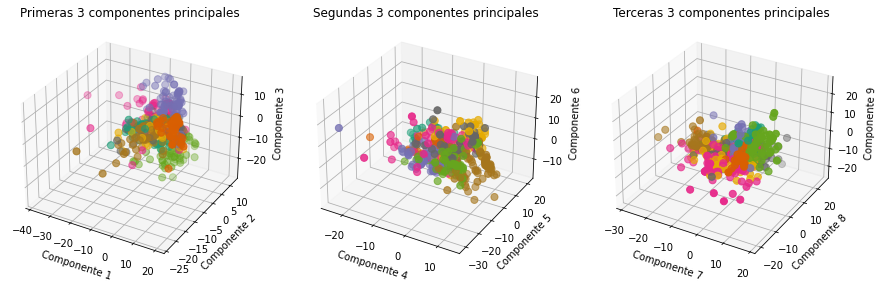

In [11]:
W_oja, o_oja = oja_generalizada(training, 9, 1e-05, 5000, 1e-06) #Mejor modelo: tarda 4 minutos aproximadamente
#W_oja, o_oja = oja_generalizada(training, 9, 1e-05, 1000, 1e-05) #Buen modelo: tarda poco más de 1 minuto
#W_oja, o_oja = oja_generalizada(training, 9, 1e-05, 500, 1e-04) #Buen modelo: tarda aproximadamente 20 segundos

Y_oja = training@W_oja
plot_components_in_3d(Y_oja, training_idx, data_with_labels, "Regla de Oja Generalizada")

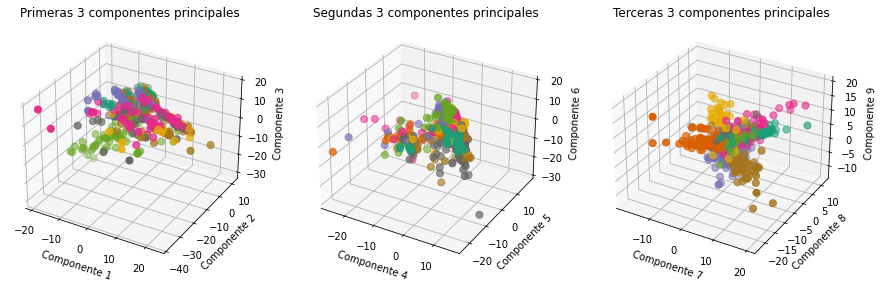

In [12]:
W_sanger, o_sanger = sanger(training, 9, 1e-05, 5000, 1e-06) #Mejor modelo: tarda 5 minutos aproximadamente
# W_sanger, o_sanger = sanger(training, 9, 1e-04, 1000, 1e-05) #Buen modelo: tarda 2 minutos aproximadamente
# W_sanger, o_sanger = sanger(training, 9, 1e-04, 500, 1e-04) #Buen modelo: tarda 40 segundos aproximadamente

Y_sanger = training@W_sanger
plot_components_in_3d(Y_sanger, training_idx, data_with_labels, "Regla de Sanger")

Las siguientes secciones de código se usaron para encontrar el mejor modelo con la regla de Oja y Sanger. 

La idea fue probar con distintos valores de:
* Épocas: se incrementaron gradualmente las iteraciones para evaluar cómo afectaba al rendimiento del modelo. Se observó si había mejoras significativas o si se alcanzaba un punto de convergencia.
* Learning rates iniciales: con cuanto empieza aprendiendo
* Decay rate: que tan rápido bajamos el learning rate

El objetivo principal es encontrar la combinación óptima para obtener la menor ortogonalidad posible.

In [ ]:
epochs_list = [10, 50, 100, 500, 1000, 2500, 5000] 
lr_list = [0.00001, 0.0001] 
decay_rate_list = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]  

In [ ]:
for epochs in epochs_list:
    for lr in lr_list:
        for decay_rate in decay_rate_list:
            print(decay_rate, lr, epochs, oja_generalizada(training, 9, lr, epochs, decay_rate)[1][-1])

Los 10 modelos con la menor ortogonalidad con la regla de Oja generalizada son los siguientes:

| Epocas | Learning Rate | Decay Rate | Ortogonalidad    |
| ------ | ------------- | ---------- | ---------------- |
| 5000   | 1e-05         | 1e-06      | 0.000223         |
| 5000   | 1e-04         | 1e-06      | 0.000278         |
| 5000   | 1e-05         | 1e-05      | 0.000627         |
| 2500   | 1e-05         | 1e-05      | 0.000634         |
| 1000   | 1e-05         | 1e-05      | 0.000765         |
| 2500   | 1e-04         | 1e-05      | 0.000833         |
| 5000   | 1e-04         | 1e-05      | 0.000843         |
| 2500   | 1e-05         | 1e-06      | 0.001111         |
| 2500   | 1e-05         | 1e-04      | 0.001560         |
| 1000   | 1e-05         | 1e-04      | 0.001720         |
| 500    | 1e-05         | 1e-04      | 0.001753         |


Al analizar los resultados, podemos observar que los modelos con un mayor número de épocas de entrenamiento, como 5000, tienden a tener menor ortogonalidad. Esto indica que a medida que aumentamos la cantidad de épocas, el modelo se adapta mejor a los datos. Lo que si se puede tener en cuenta es tener un balance respecto tiempo y cuanto más mejora aumentar las épocas. Podemos ver que con 1000 épocas se puede tener un buen módelo bajando mucho el tiempo. Para tener un ejemplo a consideración, el primer módelo nos tardó 3 minutos con 45 segundos mientras el primero de 1000 épocas nos tardó 1 minuto con 15 segundos. Incluso, el de 500 épocas consideramos que sigue siendo un buen modelo y no tarda más de medio minuto.

En cuanto a los valores de learning rate y decay rate, encontramos una variedad de combinaciones que han obtenido buenos resultados en términos de ortogonalidad así que no vemos correlación tan directa con la ortogonalidad. Igualmente, podemos notar, que no aparece ninguno de los 2 valores mayores a 0.0001 testeados en el decay_rate ni el menor valor (1e-07).

In [ ]:
for epochs in epochs_list:
    for lr in lr_list:
        for decay_rate in decay_rate_list:
            print(decay_rate, lr, epochs, sanger(training, 9, lr, epochs, decay_rate)[1][-1])

Los 10 modelos con la menor ortogonalidad con la regla de Sanger son los siguientes:

| Epocas | Learning Rate | Decay Rate | Ortogonalidad |
| ------ | ------------- | ---------- | ------------- |
| 5000   | 1e-05         | 1e-06      | 0.001065      |
| 5000   | 1e-04         | 1e-06      | 0.001331      |
| 2500   | 1e-04         | 1e-05      | 0.003786      |
| 5000   | 1e-04         | 1e-05      | 0.003786      |
| 2500   | 1e-05         | 1e-05      | 0.004773      |
| 5000   | 1e-05         | 1e-05      | 0.004886      |
| 2500   | 1e-05         | 1e-06      | 0.005027      |
| 1000   | 1e-04         | 1e-05      | 0.009478      |
| 5000   | 1e-04         | 1e-04      | 0.010467      |
| 2500   | 1e-04         | 1e-04      | 0.010467      |
| 500    | 1e-04         | 1e-04      | 0.010468      |

Podemos ver que es un caso parecido al de la Oja generalizada. En primer lugar, nuevamente, podemos notar que el número de épocas de entrenamiento parece tener una influencia significativa en la ortogonalidad alcanzada por los modelos. A medida que aumentamos el número de épocas, observamos una disminución en la ortogonalidad. Esto indica que a medida que el modelo se entrena durante más tiempo, logra una mejor adaptación a los datos. En este caso el primer modelo tomó 5 minutos en ejecutarse mientras que el de 1000 épocas tomó poco menos de 2 minutos

Luego, se ve el mismo resultado respecto learning rate y el decay rate.

Al comparar los resultados de los dos conjuntos de parámetros de prueba, podemos concluir que, en esta configuración específica, la regla de la Oja produjo mejores resultados en términos de ortogonalidad. Además, también se observó que la implementación de la regla de la Oja tuvo un tiempo de ejecución más rápido en cada una de las instancias. Estas observaciones sugieren que la regla de la Oja es una opción más eficiente para este escenario de entrenamiento. 

### 2.2 Mapeo de características

In [75]:
W_kohonen,y_kohonen = kohonen_map(training, 9)

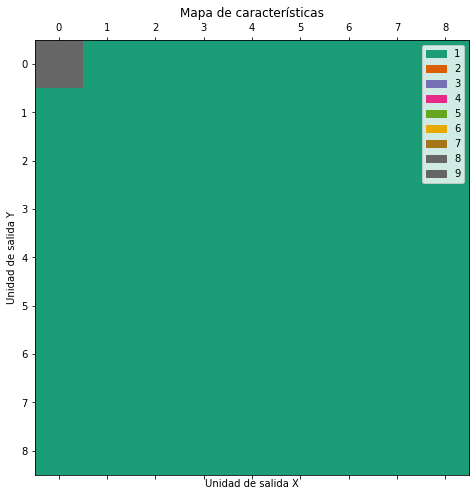

In [76]:
plot_category_maps(training, W_kohonen, data_with_labels[training_idx , 0])